In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')
from impala.dbapi import connect
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_colwidth',1000)
from matplotlib.font_manager import FontProperties
chinese = FontProperties(fname = 'C:/Windows/Fonts/msyh.ttc')
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# data = pd.read_csv("D:/GitHub/datasets/190821_ShopOrders.csv")

# 查询所有字段
def list_col(localhost,database, port,tabls_name):
    db = connect(localhost,port,database)
    cursor = db.cursor()
    cursor.execute("select * from %s" % tabls_name)
    col_name_list = [tuple[0] for tuple in cursor.description]
    db.close()
    return col_name_list

# 列出所有的表
def list_table(localhost,database,port):
    db = connect(localhost,database,port)
    cursor = db.cursor()
    cursor.execute("show tables")
    table_list = [tuple[0] for tuple in cursor.fetchall()]
    db.close()
    return table_list

# 数据库信息
port = 21050 # 端口号
host = "172.22.210.29" # 连接地址
database = "bigtables" # 数据库名
tabls_name = "shop_order" # 表名

table_names = list_table(host,port,database) 
# print('库中所有表名:',*table_names,sep = '\n  ')
column_names = list_col(host,database, port,tabls_name)
# print('表中所有字段名:',*column_names,sep = '\n  ')

conn = connect(host=host,port =port , database = database,timeout=3600 )
cur_data = conn.cursor()
cur_data.execute('''SELECT * from shop_order;''')
data=cur_data.fetchall()
data = pd.DataFrame(data,columns=column_names)

In [3]:
data.shape

(335281, 52)

In [4]:
# data.to_csv("D:/GitHub/datasets/shop_order_190821.csv",index=False)


In [5]:
data1 = data.copy()

In [6]:
data1 = data1[data1["status"] == 1]
data1.shape

(222983, 52)

In [7]:
df = data1[["user_id","create_date","payable_rmb_amount","buy_num"]]
df["create_date"] = pd.to_datetime(df["create_date"])
df["date"] = df["create_date"].dt.date
df["month"] = df["date"].values.astype('datetime64[M]')

In [8]:
df.head()

,user_id,create_date,payable_rmb_amount,buy_num,date,month
4,71,2018-12-28 19:48:29,7.0,1.0,2018-12-28,2018-12-01
15,37,2018-12-28 22:03:50,10.0,1.0,2018-12-28,2018-12-01
16,956535,2018-12-28 22:06:59,133.0,1.0,2018-12-28,2018-12-01
17,1009675,2018-12-28 22:59:43,17.0,1.0,2018-12-28,2018-12-01
18,37,2018-12-28 23:05:29,17.0,1.0,2018-12-28,2018-12-01


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222983 entries, 4 to 335277
Data columns (total 6 columns):
user_id               222983 non-null object
create_date           222983 non-null datetime64[ns]
payable_rmb_amount    222983 non-null float64
buy_num               222983 non-null float64
date                  222983 non-null object
month                 222983 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 11.9+ MB


In [10]:
# 共222983单支付成功，平均每单消费7.16元，75%消费6元以下
df.describe()

,payable_rmb_amount,buy_num
count,222983.000000,222983.0
mean,7.156496,1.0
std,14.302916,0.0
min,0.000000,1.0
25%,3.990000,1.0
50%,4.990000,1.0
75%,5.990000,1.0
max,365.000000,1.0


In [11]:
# 按用户分组
user_grouped = df.groupby("user_id").sum()

In [12]:
user_grouped.head()

,payable_rmb_amount,buy_num
user_id,,
10,0.00,1.0
10000055,9.98,2.0
10000061,3.99,1.0
10000128,0.99,1.0
10000353,17.18,3.0


In [13]:
# 用户数101911人(截止190822下午)，人均消费15.65元.75%用户消费17元以下
# 
user_grouped.describe()

,payable_rmb_amount,buy_num
count,101911.000000,101911.000000
mean,15.658535,2.188017
std,28.771613,2.490335
min,0.000000,1.000000
25%,3.990000,1.000000
50%,7.000000,1.000000
75%,16.990000,2.000000
max,1062.550000,262.000000


Text(0.5, 1.0, '各月用户支付金额')

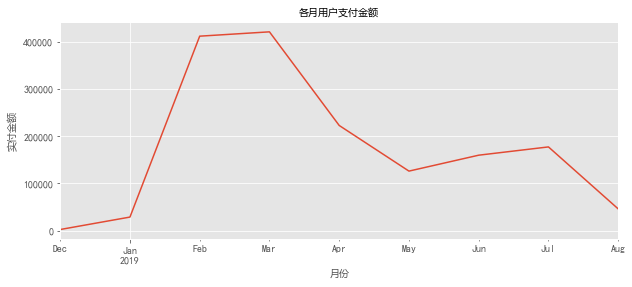

In [14]:
plt.figure(figsize = (10,4))
ax = df.groupby('month').payable_rmb_amount.sum().plot()
ax.set_xlabel("月份",fontproperties=chinese)
ax.set_ylabel("实付金额",fontproperties=chinese)
ax.set_title("各月用户支付金额",fontproperties=chinese)

#### 19年2-3月销量达到高峰，之后4-5出现一次大幅下降，最后趋于平稳

Text(0.5, 1.0, '各月用户购买商品数(订单数)')

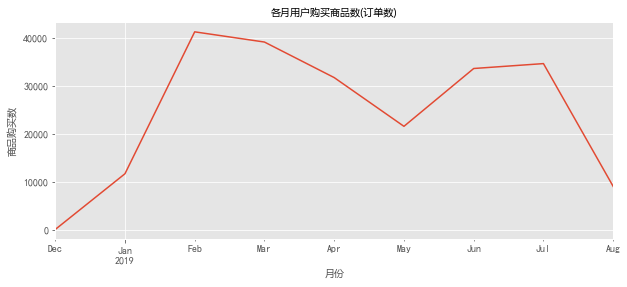

In [15]:
plt.figure(figsize = (10,4))
ax = df.groupby('month').buy_num.sum().plot()
ax.set_xlabel("月份",fontproperties=chinese)
ax.set_ylabel("商品购买数",fontproperties=chinese)
ax.set_title("各月用户购买商品数(订单数)",fontproperties=chinese)

##### 4月销量下滑趋势没有金额幅度大，可能是商品价格下降导致

Text(0.5, 1.0, '各用户实付金额与购买商品数关系')

<Figure size 1440x576 with 0 Axes>

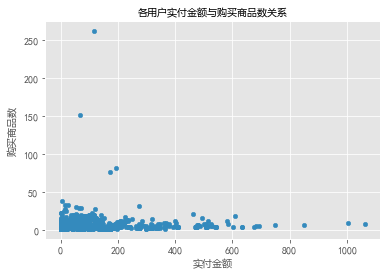

In [16]:
plt.figure(figsize = (20,8))
ax = df.groupby('user_id').sum().plot.scatter("payable_rmb_amount","buy_num")
ax.set_xlabel("实付金额",fontproperties=chinese)
ax.set_ylabel("购买商品数",fontproperties=chinese)
ax.set_title("各用户实付金额与购买商品数关系",fontproperties=chinese)

#### 总体还算正常，有极少数异常值，但数量不够影响全局

Text(0.5, 1.0, '用户购买商品数分布')

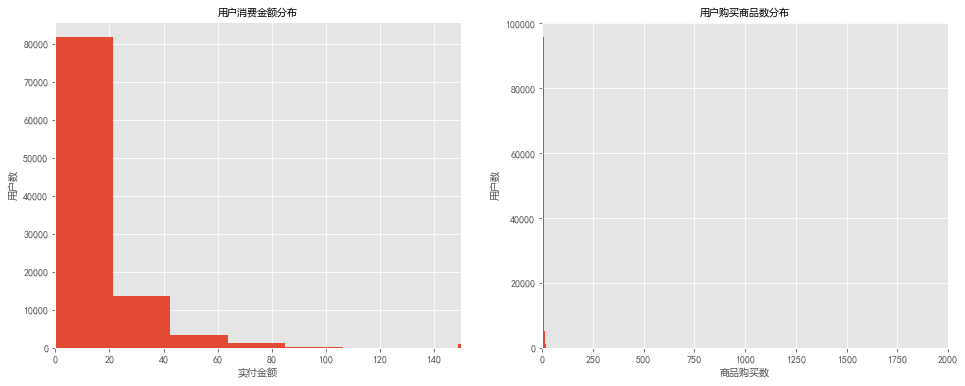

In [17]:
# 画个直方图看看分布
plt.figure(figsize=(16,6))
plt.subplot(121)
ax = df.groupby("user_id").payable_rmb_amount.sum().hist(bins = 50)
ax.set_xlabel("实付金额",fontproperties=chinese)
ax.set_ylabel("用户数",fontproperties=chinese)
ax.set_xlim(0,150)
ax.set_title("用户消费金额分布",fontproperties = chinese)
plt.subplot(122)
ax = df.groupby('user_id').buy_num.count().hist(bins = 50)
ax.set_xlabel('商品购买数',fontproperties = chinese)
ax.set_ylabel("用户数",fontproperties = chinese)
ax.set_xlim(0,2000)
ax.set_title("用户购买商品数分布",fontproperties = chinese)

In [18]:
print("用户首次消费月份(每月新客数)")
print(df.groupby("user_id").month.min().value_counts())

用户首次消费月份(每月新客数)
2019-02-01    35095
2019-03-01    22004
2019-04-01    12294
2019-01-01    10930
2019-06-01     9280
2019-05-01     6046
2019-07-01     4420
2019-08-01     1786
2018-12-01       56
Name: month, dtype: int64


In [19]:
print("用户末次消费月份：(末次消费)")
print(df.groupby('user_id').month.max().value_counts())

用户末次消费月份：(末次消费)
2019-02-01    27370
2019-03-01    18260
2019-04-01    13375
2019-07-01    12861
2019-06-01    10728
2019-01-01     7477
2019-08-01     6849
2019-05-01     4968
2018-12-01       23
Name: month, dtype: int64


### 复购率:当月购买2次及以上为复购用户

In [20]:
# 算出每个用户下单月份
df_FuGou = df.pivot_table(index='user_id',columns='month',
                             values='date',aggfunc='count').fillna(0)
df_FuGou.head(10)

month,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00
user_id,,,,,,,,,
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10000055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
10000061,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10000128,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10000353,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10000379,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10000422,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0
1000050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10000568,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
# 数据转化，消费两次及以上的记为1，一次记为0，没有消费记为NaN
df_FuGou_transf = df_FuGou.applymap(lambda x:1 if x > 1 else np.NaN if x == 0 else 0)

Text(0.5, 1.0, '各月复购率')

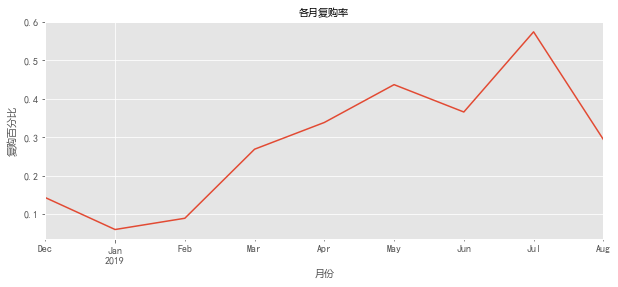

In [22]:
#计算复购率并作图
ax = (df_FuGou_transf.sum()/df_FuGou_transf.count()).plot(figsize = (10,4))
ax.set_xlabel("月份",fontproperties=chinese)
ax.set_ylabel("复购百分比",fontproperties=chinese)
ax.set_title("各月复购率",fontproperties=chinese)

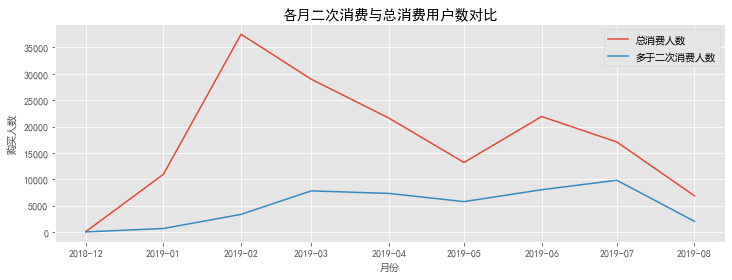

In [25]:
# 细分一下

fig , ax = plt.subplots(figsize = (12,4))
ax.plot(df_FuGou_transf.count())
ax.plot(df_FuGou_transf.sum())
ax.set_xlabel("月份",fontproperties=chinese)
ax.set_ylabel("购买人数",fontproperties=chinese)
ax.set_title("各月二次消费与总消费用户数对比")
legends = ["总消费人数","多于二次消费人数"]
ax.legend(legends,prop=chinese,loc='upper right')

##### 复购人数从19年3月起开始趋于稳定，证明沉淀下来此部分用户忠诚度很高。

### 回购率：某时间段内消费的用户，在下个时间周期内仍消费的占比。

In [28]:
# 算出每个用户各月购买次数
df_HuiGou = df.pivot_table(index="user_id",columns="month",
                          values="date",aggfunc='count').fillna(0)
df_HuiGou.head()

month,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00
user_id,,,,,,,,,
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10000055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
10000061,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10000128,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10000353,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [30]:
# 数据转化，购买过为1，没买为0
df_HuiGou_transf = df_HuiGou.applymap(lambda x:1 if x>0 else 0)
df_HuiGou_transf.head(10)

month,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00
user_id,,,,,,,,,
10,0,0,0,0,0,0,0,0,1
10000055,0,0,0,0,0,0,1,1,0
10000061,0,0,0,0,0,1,0,0,0
10000128,0,0,0,0,1,0,0,0,0
10000353,0,1,0,0,1,1,0,0,0
10000379,0,0,1,0,0,0,0,0,0
10000422,0,0,0,0,0,1,1,1,0
1000050,0,0,0,0,0,0,0,1,0
10000568,0,0,0,0,0,0,1,0,0


In [38]:
#定义函数，每个月都要跟后面一个月对比下，
#本月有消费且下月也有消费，则本月记为1，
#本月有消费且下月没有消费，则本月记为0，
#本月没有消费则为NaN，
#由于最后个月没有下月数据，规定全为NaN
def purchase_return(data):
    status = []
    for i in range(8):
        if data[i] == 1:
            if data[i+1] == 1:
                status.append(1)
            if data[i+1] == 0:
                status.append(0)
        else:
            status.append(np.NaN)
    status.append(np.NaN)       
    return pd.Series(status)
#     return status
    

In [39]:
df_HuiGou_return = df_HuiGou_transf.apply(purchase_return, axis = 1)
df_HuiGou_return.head()

,0,1,2,3,4,5,6,7,8
user_id,,,,,,,,,
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000055,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN
10000061,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
10000128,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
10000353,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN


In [42]:
# 出图看看
columns = df.month.sort_values().unique()
df_HuiGou_return.columns = columns

Text(0.5, 1.0, '各月回购率')

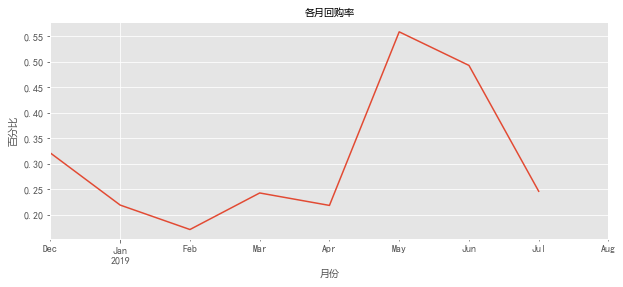

In [43]:
ax = (df_HuiGou_return.sum()/df_HuiGou_return.count()).plot(figsize = (10,4))
ax.set_xlabel("月份",fontproperties=chinese)
ax.set_ylabel("百分比",fontproperties=chinese)
ax.set_title("各月回购率",fontproperties=chinese)

##### 6，7月上了什么产品或活动吗？ 回购率超过50%

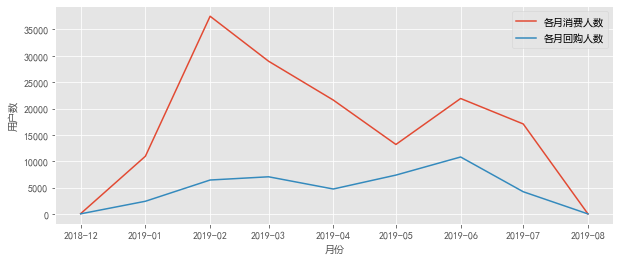

In [46]:
# 细化一下

fig,ax = plt.subplots(figsize = (10,4))
ax.plot(df_HuiGou_return.count()) # 消费人数
ax.plot(df_HuiGou_return.sum()) # 回购人数
ax.set_xlabel("月份",fontproperties=chinese)
ax.set_ylabel("用户数",fontproperties=chinese)
legends = ["各月消费人数","各月回购人数"]
ax.legend(legends,prop=chinese,loc="upper right")

#####  与复购人数接近，5000-10000，趋势平稳，证明这部分用户已经养成了固定使用消费习惯。应该是同一拨人，稍后会验证一下。 但是7月表现出下滑趋势。

#### 2率都呈现上升趋势，后几个月基本与总消费人数变化趋势相近

### 用户分层
##### 新用户的定义是第一次消费。活跃用户即老客，在某一个时间窗口内有过消费。不活跃用户则是时间窗口内没有消费过的老客。回流用户是在上一个窗口中没有消费，而在当前时间窗口内有过消费。以上的时间窗口都是按月统计。

In [66]:
def active_status(data):
    status = []
    for i in range(9):
        
        #若本月没有消费
        if data[i] == 0:
            if len(status) > 0:
                if status[i-1] == '未注册':
                    status.append('未注册')
                else:
                    status.append('不活跃')
            else:
                status.append('未注册')
                
        # 若本月有消费
        else:
            if len(status) == 0:
                status.append('新客')
            else:
                if status[i-1] == '不活跃':
                    status.append('回流用户')
                elif status[i-1] == '未注册':
                    status.append('新客')
                else:
                    status.append('活跃')
    return status

In [67]:
# df_PurchaseStatus = 
df_FenCeng = df.pivot_table(index="user_id",columns="month",
                          values="date",aggfunc='count').fillna(0)
df_FenCeng.head()

month,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00
user_id,,,,,,,,,
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10000055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
10000061,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10000128,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10000353,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [68]:
# 数据转化，购买过为1，没买为0
df_FenCeng_transf = df_FenCeng.applymap(lambda x:1 if x>0 else 0)
df_FenCeng_transf.head(10)

month,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00
user_id,,,,,,,,,
10,0,0,0,0,0,0,0,0,1
10000055,0,0,0,0,0,0,1,1,0
10000061,0,0,0,0,0,1,0,0,0
10000128,0,0,0,0,1,0,0,0,0
10000353,0,1,0,0,1,1,0,0,0
10000379,0,0,1,0,0,0,0,0,0
10000422,0,0,0,0,0,1,1,1,0
1000050,0,0,0,0,0,0,0,1,0
10000568,0,0,0,0,0,0,1,0,0


In [69]:
df_FenCeng_status = df_FenCeng_transf.apply(lambda x: pd.Series(active_status(x)),axis=1)
df_FenCeng_status.columns = columns
df_FenCeng_status.head()

,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00
user_id,,,,,,,,,
10,未注册,未注册,未注册,未注册,未注册,未注册,未注册,未注册,新客
10000055,未注册,未注册,未注册,未注册,未注册,未注册,新客,活跃,不活跃
10000061,未注册,未注册,未注册,未注册,未注册,新客,不活跃,不活跃,不活跃
10000128,未注册,未注册,未注册,未注册,新客,不活跃,不活跃,不活跃,不活跃
10000353,未注册,新客,不活跃,不活跃,回流用户,活跃,不活跃,不活跃,不活跃


In [70]:
# 统计每月各分类用户，未注册用户数不计数替换成NaN
df_FenCeng_count = df_FenCeng_status.replace("未注册",np.NaN).apply(lambda x:pd.value_counts(x))
df_FenCeng_count

,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00
不活跃,NaN,38.0,8572,39108,58774,73247,73804,83057,95062
回流用户,NaN,NaN,12,540,2265,2406,5254,1846,856
新客,56.0,10930.0,35095,22004,12294,6046,9280,4420,1786
活跃,NaN,18.0,2402,6433,7046,4726,7367,10802,4207


Text(0.5, 1.0, '各月各类用户占比')

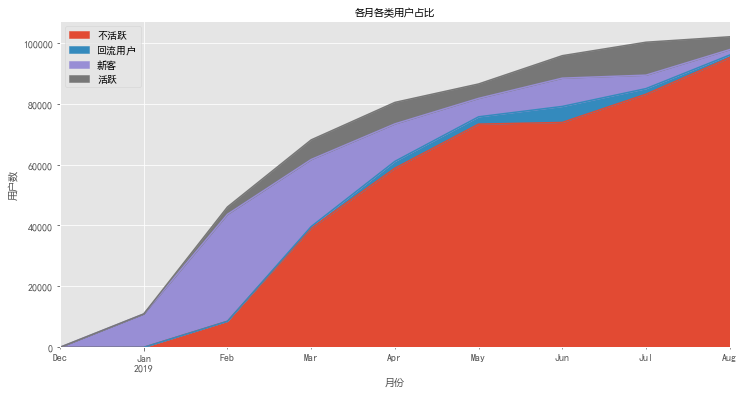

In [73]:
# 出图看看
ax = df_FenCeng_count.fillna(0).T.plot.area(figsize = (12,6))
ax.set_xlabel("月份", fontproperties=chinese)
ax.set_ylabel("用户数", fontproperties=chinese)
ax.set_title("各月各类用户占比", fontproperties=chinese)

In [74]:
# 回流占比：某个时间窗口内回流用户在总用户中的占比。
return_rate = df_FenCeng_count.apply(lambda x: x/x.sum())

In [75]:
return_rate

,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00
不活跃,NaN,0.003459,0.186020,0.574400,0.731211,0.847521,0.771161,0.829533,0.932794
回流用户,NaN,NaN,0.000260,0.007931,0.028179,0.027839,0.054898,0.018437,0.008399
新客,1.0,0.994903,0.761594,0.323184,0.152950,0.069957,0.096965,0.044145,0.017525
活跃,NaN,0.001638,0.052126,0.094485,0.087660,0.054683,0.076976,0.107885,0.041281


Text(0.5, 1.0, '每月回流用户占比')

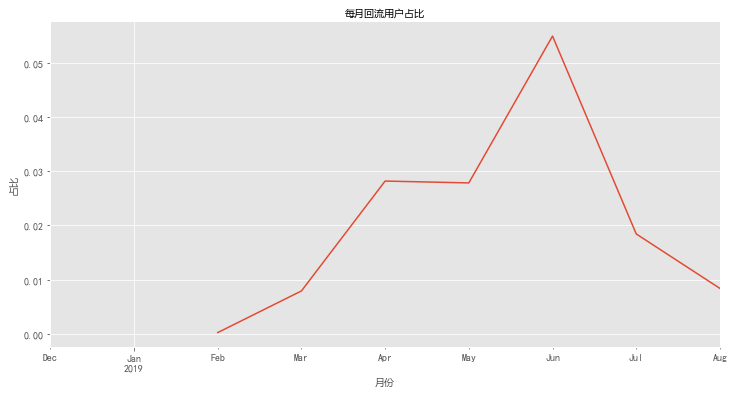

In [76]:
ax = return_rate.loc['回流用户'].plot(figsize = (12,6))
ax.set_xlabel('月份', fontproperties=chinese) 
ax.set_ylabel('占比', fontproperties=chinese) 
ax.set_title('每月回流用户占比', fontproperties=chinese)

Text(0.5, 1.0, '每月活跃用户占比')

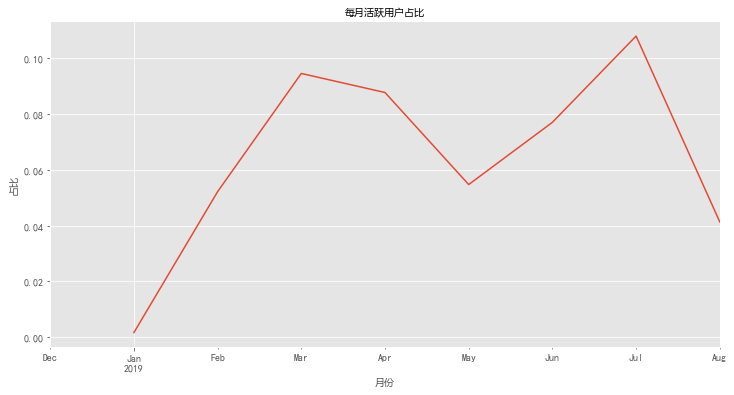

In [77]:
ax = return_rate.loc['活跃'].plot(figsize = (12,6))
ax.set_xlabel('月份', fontproperties=chinese) 
ax.set_ylabel('占比', fontproperties=chinese) 
ax.set_title('每月活跃用户占比', fontproperties=chinese)

### 用户质量：高质量用户贡献了多少消费？

In [81]:
user_amount = df.groupby("user_id").payable_rmb_amount.sum().sort_values().reset_index()
user_amount['amount_cumsum'] = user_amount.payable_rmb_amount.cumsum()

In [82]:
user_amount.tail()

,user_id,payable_rmb_amount,amount_cumsum
101906,6999864,693.00,1.592111e+06
101907,2798554,749.00,1.592860e+06
101908,3282631,848.99,1.593709e+06
101909,645982,1005.00,1.594714e+06
101910,3785486,1062.55,1.595777e+06


Text(0.5, 1.0, '用户累计贡献金额百分比')

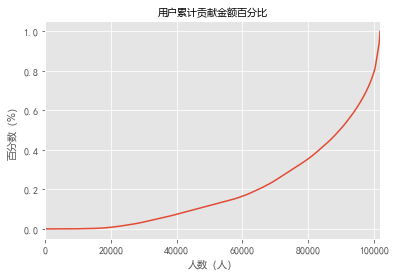

In [83]:
#计算出各阶段金额占总金额的百分比
amount_total = user_amount.amount_cumsum.max()
user_amount['prop'] = user_amount.amount_cumsum.apply(lambda x: x / amount_total)
ax = user_amount.prop.plot()
ax.set_xlabel('人数（人）', fontproperties=chinese) 
ax.set_ylabel('百分数（%）', fontproperties=chinese) 
ax.set_title('用户累计贡献金额百分比', fontproperties=chinese)

##### 典型的二八分布，共101911人中，前80000人贡献了不到40%的消费。。。